# Информационный поиск

Скачиваем классический набор данных -- набор текстов об аэронавтике CRANFIELD:

In [1]:
! wget -q http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
! tar -xvf cran.tar.gz
! rm cran.tar.gz*

cran.all.1400
cran.qry
cranqrel
cranqrel.readme


Берём только сами запросы (это будут наши документы):

In [2]:
! grep -v "^\." cran.qry > just.qry
! head -3 just.qry

what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .
what are the structural and aeroelastic problems associated with flight


Объединяем многострочные в один:

In [3]:
raw_query_data = [line.strip() for line in open("just.qry", "r").readlines()]
query_data = [""]

for query_part in raw_query_data:
  query_data[-1] += query_part + " "
  if query_part.endswith("."):
    query_data.append("")

query_data[:2] #Выведем пару документов для примера

['what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft . ',
 'what are the structural and aeroelastic problems associated with flight of high speed aircraft . ']

Составим запросы к нашим документам:

In [4]:
QUERIES = ['theory of bending', 'aeroelastic effects']

## Boolean retrieval
Представим каждый документ как "битовую маску": вектор размером со словарь, в котором на каждой позиции единица, если в документе есть соответсвующий терм, и ноль, если терма нет:

In [5]:
# В разных версиях ответы могут отличаться, поэтому важно иметь одну и ту же
! pip install -q scikit-learn==0.22.2.post1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
ERROR: Could not build wheels for scikit-learn, which is required to install pyproject.toml-based projects


In [6]:
from  sklearn.feature_extraction.text import CountVectorizer

In [7]:
encoder = CountVectorizer(binary=True)
encoded_data = encoder.fit_transform(query_data)
encoded_queries = encoder.transform(QUERIES)
list(encoder.vocabulary_)[:3]

['what', 'similarity', 'laws']

Посмотрим на представление первого предложения:

In [8]:
id2term = {idx: term for term, idx in encoder.vocabulary_.items()}
non_zero_values_ids = encoded_data[0].nonzero()[1]

terms = [id2term[idx] for idx in non_zero_values_ids]
terms

['what',
 'similarity',
 'laws',
 'must',
 'be',
 'obeyed',
 'when',
 'constructing',
 'aeroelastic',
 'models',
 'of',
 'heated',
 'high',
 'speed',
 'aircraft']

Всё так.

## Задание 0

Теперь для каждого из данных запросов `QUERIES` найдём ближайший для него документ из `query_data` по сходству Жаккара. Есть более эффективные способы это сделать, но вам требуется реализовать расстояние Жаккара и далее применить его к нашим данным:

In [9]:
import numpy as np

def jaccard_sim(vector_a: np.array, vector_b: np.array) -> float:
    """
    Сходство или коэффициент Жаккара: отношение мощности пересечения
    к мощности объединения
    """
    intersection = np.logical_and(vector_a, vector_b).sum()
    union = np.logical_or(vector_a, vector_b).sum()

    return intersection / union

#Проверка, что функция работает правильно
assert jaccard_sim(np.array([1, 0, 1, 0, 1]), np.array([0, 1, 1, 1, 1])) == 0.4

Здесь документы представлены так же, как строки в матрице термов-документов. Каждая ячейка вектора отвечает за наличие/отсутствие конкретного элемента (например, слова-терма, когда у нас в словаре всего 5 слов). В первом случае их три, во втором — четыре. Объединение — все пять возможных элементов. Пересечение — два. Отсюда и 0.4.

## Задание 1
Теперь с помощью кода ниже вычислите для каждого запроса самые близкие документы:

In [10]:
for q_id, query in enumerate(encoded_queries):
    # Приводим к нужному типу
    query = query.todense().A1
    docs = [doc.todense().A1 for doc in encoded_data]
    # Вычисляем коэфф. Жаккара
    id2doc2similarity = [(doc_id, doc, jaccard_sim(query, doc)) for doc_id, doc in enumerate(docs)]
    # Сортируем по нему
    closest = sorted(id2doc2similarity, key=lambda x: x[2], reverse=True)

    print("Q: %s\nFOUND:" % QUERIES[q_id])
    # Выводим по 3 наиболее близких документа для каждого запроса
    for closest_id, _, sim in closest[:3]:
        print("    %d\t%.2f\t%s" %(closest_id, sim, query_data[closest_id]))

Q: theory of bending
FOUND:
    42	0.20	what are the details of the rigorous kinetic theory of gases . 
    43	0.20	(chapman-enskog theory) . 
    146	0.19	does a membrane theory exist by which the behaviour of pressurized membrane cylinders in bending can be predicted . 
Q: aeroelastic effects
FOUND:
    196	0.14	the problem of similarity for representative investigation of aeroelastic effects in a flow with the absence of heating effects . 
    204	0.12	do viscous effects seriously modify pressure distributions . 
    114	0.12	is the problem of similarity for representative investigations of aeroelastic effects in heated flow as intractable as previous investigations imply . 


Видим, что кое-где просачиваются  тексты, которых с запросами объединяют малозначительные термы, но при этом коэффициент Жаккара — наша функция ранжирования! — высок.

# VSM

Попробуем теперь сделать то же, но с tf-idf и косинусным расстоянием. Мы сделаем всё опять "руками", но "в реальной жизни" лучше использоватьесть эффективные реализации cosine distance, например, из библиотеки scipy:

In [11]:
from  sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
# Совет: обязательно разберитесь с тем, какие возможности
# предоставляет tf-idf vectorizer, какие параметры за что отвечают

tfidf_encoder = TfidfVectorizer()
tfidf_encoded_data = tfidf_encoder.fit_transform(query_data)
tfidf_encoded_queries = tfidf_encoder.transform(QUERIES)

list(tfidf_encoder.vocabulary_)[:3]

['what', 'similarity', 'laws']

## Задание 2
Реализовать косинусное расстояние:

In [13]:
def cosine_distance(vector_a: np.array, vector_b: np.array) -> float:
    """
    Косинусное расстояние: единица минус отношение скалярного произведения
    на произведение L2-норм (подсказка: в numpy такие нормы есть)
    """
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)

    if norm_a == 0 or norm_b == 0:
        return np.nan  # Возвращаем NaN в случае нулевой нормы

    return 1 - dot_product / (norm_a * norm_b)

# Проверка, что функция работает правильно
assert cosine_distance(np.array([1, 0, 1, 1, 1]), np.array([0, 0, 1, 0, 0])) == 0.5


Теперь вычислим ближайшие по косинусному расстоянию между векторными представлениями документов и запросов:

In [14]:
for q_id, query in enumerate(tfidf_encoded_queries):
    # приводим к нужному типу
    query = query.todense().A1
    docs = [doc.todense().A1 for doc in tfidf_encoded_data]
    # Косинусное расстояние
    id2doc2similarity = [(doc_id, doc, cosine_distance(query, doc)) \
                        for doc_id, doc in enumerate(docs)]
    # сортируем по нему
    closest = sorted(id2doc2similarity, key=lambda x: x[2], reverse=False)

    print("Q: %s\nFOUND:" % QUERIES[q_id])

    for closest_id, _, sim in closest[:3]:
        print("    %d\t%.2f\t%s" %(closest_id, sim, query_data[closest_id]))

Q: theory of bending
FOUND:
    145	0.65	what are the best experimental data and classical small deflection theory analyses available for pressurized cylinders in bending . 
    146	0.66	does a membrane theory exist by which the behaviour of pressurized membrane cylinders in bending can be predicted . 
    111	0.66	has the solution of the clamped plate problem,  in the classical theory of bending,  been reduced to two successive membrane boundary value problems . 
Q: aeroelastic effects
FOUND:
    196	0.51	the problem of similarity for representative investigation of aeroelastic effects in a flow with the absence of heating effects . 
    114	0.70	is the problem of similarity for representative investigations of aeroelastic effects in heated flow as intractable as previous investigations imply . 
    1	0.74	what are the structural and aeroelastic problems associated with flight of high speed aircraft . 


# Индивидуальное задание

Используя в качестве документов тексты запросов из набора текстов об аэронавтике **CRANFIELD** (те же, что и в примере), найдите пару наиболее близких к указанному запросу документа.  
<br>

_Текст запроса:_ **aerodynamic problems**.  

1. Введите индекс наиболее близкого документа согласно мере Жаккара.
Введите целое неотрицательное число:
    ```
    4
    ```  
2. Введите значение коэффициента Жаккара для наиболее близкого документа. Десятичный разделитель точка. Ответ округлите до сотых:
    ```
    0.2
    ```
3. Введите индекс второго по близости документа согласно мере Жаккара.
Введите целое неотрицательное число:
    ```
    108
    ```
4. Введите значение коэффициента Жаккара для второго по близости документа. Десятичный разделитель точка. Ответ округлите до сотых:
    ```
    0.17
    ```
  
<br>

_Текст запроса:_ **interference effects**.

1. Введите индекс наиболее близкого документа относительно косинусного расстояния. Введите целое неотрицательное число:
    ```
    90
    ```
2. Введите значение косинусного расстояния для наиболее близкого документа. Десятичный разделитель точка. Ответ округлите до сотых:
    ```
    0.5
    ```
3. Введите индекс второго по близости документа относительно косинусного расстояния. Введите целое неотрицательное число:
    ```
    33
    ```
4. Введите значение косинусного расстояния для второго по близости документа. Десятичный разделитель точка. Ответ округлите до сотых:
    ```
    0.59
    ```


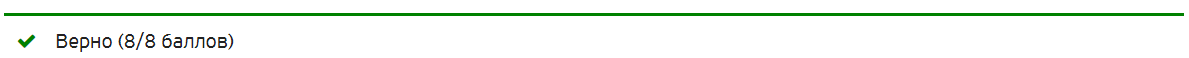

In [15]:
query = "aerodynamic problems"

# Вычислим расстояние между запросом и каждым документом по мере Жаккара
jaccard_sims = []
for doc_data in query_data:
    doc_vector = tfidf_encoder.transform([doc_data])
    query_vector = tfidf_encoder.transform([query])
    jaccard_similarity = jaccard_sim(doc_vector.toarray()[0], query_vector.toarray()[0])
    jaccard_sims.append(jaccard_similarity)

# Найдем индексы двух наиболее близких документов
top_indices = np.argsort(jaccard_sims)[-2:]

print("Индекс наиболее близкого документа:", top_indices[-1])
print("Значение коэффициента Жаккара для наиболее близкого документа:", round(jaccard_sims[top_indices[-1]], 2))
print("Индекс второго по близости документа:", top_indices[-2])
print("Значение коэффициента Жаккара для второго по близости документа:", round(jaccard_sims[top_indices[-2]], 2))

Индекс наиболее близкого документа: 4
Значение коэффициента Жаккара для наиболее близкого документа: 0.2
Индекс второго по близости документа: 108
Значение коэффициента Жаккара для второго по близости документа: 0.17


In [16]:
query = "interference effects"

# Вычислим расстояние между запросом и каждым документом по косинусному расстоянию
cosine_distances = []
for doc_data in query_data:
    doc_vector = tfidf_encoder.transform([doc_data])
    query_vector = tfidf_encoder.transform([query])
    cosine_dist = cosine_distance(doc_vector.toarray()[0], query_vector.toarray()[0])
    cosine_distances.append(cosine_dist)

top_indices = np.argsort(cosine_distances)[:2]

print("Индекс наиболее близкого документа:", top_indices[0])
print("Значение косинусного расстояния для наиболее близкого документа:", round(cosine_distances[top_indices[0]], 2))
print("Индекс второго по близости документа:", top_indices[1])
print("Значение косинусного расстояния для второго по близости документа:", round(cosine_distances[top_indices[1]], 2))

Индекс наиболее близкого документа: 90
Значение косинусного расстояния для наиболее близкого документа: 0.5
Индекс второго по близости документа: 33
Значение косинусного расстояния для второго по близости документа: 0.59
